# Detailed peakbagging
The detailed peakbagging stage is meant to remove the constraints from the various models we use to define the frequency pattern in the mode ID stage. 

It's possible to run the peakbag stage without doing the mode ID stage first, so that you can supply your own solutions if the mode ID is wonky. It's even possible to run it with just the angular degree and frequencies as inputs, but performs a lot better if you pass it the mode heights and widths too.

Let's start by loading in the spectrum.

**Note:** You may want to use the full resolution spectrum for the detailed peakbagging. It will take longer but should give you the highest precision on your frequencies.

In [1]:
from pbjam import IO

psd = IO.psd('KIC2991448', lk_kwargs={'exptime': 60, 'mission':'Kepler', 'author':'Kepler'}, use_cached=True)
 
psd()

f = psd.freq

s = psd.powerdensity

Using cached search result.
Loading fits files from cache.


Next we can load the result of mode identification stage as an example. In this case we've stored it as a pickled dictionary.

In [2]:
import pickle

modeID_result = pickle.load(open('Examples/KIC2991448_modeID_result.pkl', 'rb'))

In [3]:
from pbjam.peakbagging import peakbag

pb = peakbag(f, s, 
             ell=modeID_result['ell'], 
             freq=modeID_result['summary']['freq'], 
             height=modeID_result['summary']['height'], 
             width=modeID_result['summary']['width'], 
             slices=7,
             samplerType='emcee')

Using emcee to sample.
Creating envelope slices


100%|█████████████████████████████████████████████| 5/5 [00:15<00:00,  3.04s/it]


The arguments that come from the mode ID result are used to set up the priors that are used in the detailed peakbagging. 

However, notice the last two arguments to the class initialization, `slices` and `samplerType`. The slices argument tells PBjam to divide the spectrum into sections and fit those independently of one another. The alternative, fitting all the modes in the envelope at the same time, can be computationally expensive. In some cases it might take several hours to do the detailed peakbagging on a single star, while slicing up the spectrum usually only takes a few minutes. 

**Note** PBjam will try to segment the spectrum according to the requested number of slices (usually along the radial orders) but will avoid splitting $\ell=2,0$ mode pairs and other close separations. You may therefore not wind up with exactly the number of slices you requested.

Global peakbagging is however generally considered the most accurate way of fitting the spectrum, so if you have the time this is prefered. In addition, it yields far better estimates of the rotation and inclination of the stellar rotation axis, so if these are at all interesting parameters then it is recommended to use the global peakbagging. On the other hand if all you want is frequencies, then using the slicing will likely be just fine. 

The second argument, `samplerType`, referes to the choice of samplers we provide with `PBjam`. Currently the options are `emcee` and `Dynesty`. Using `emcee` is in general faster than using `Dynesty` since it samples the posterior more efficiently (if the mode ID is good), and is recommended when when running the global peakbagging (no slices). However, in the event that you have many closely spaced peaks in the spectrum, it is advisable to use `Dynesty` as nested sampling is in general better at handling multi-modal posterior distributions, whereas `emcee` can easily get stuck in local maxima. 

In the interest of time for this tutorial we'll use the slicing and `emcee`. We can now simply call the `pb` class instance to run the sampling on all the slices sequentially.

In [4]:
pb_result = pb()

Peakbagging slice 1/5
Peakbagging slice 2/5
Peakbagging slice 3/5
Peakbagging slice 4/5
Peakbagging slice 5/5
Time taken 7.7 minutes


As with the mode ID class we can use there are several plotting functions available with the peakbag class.

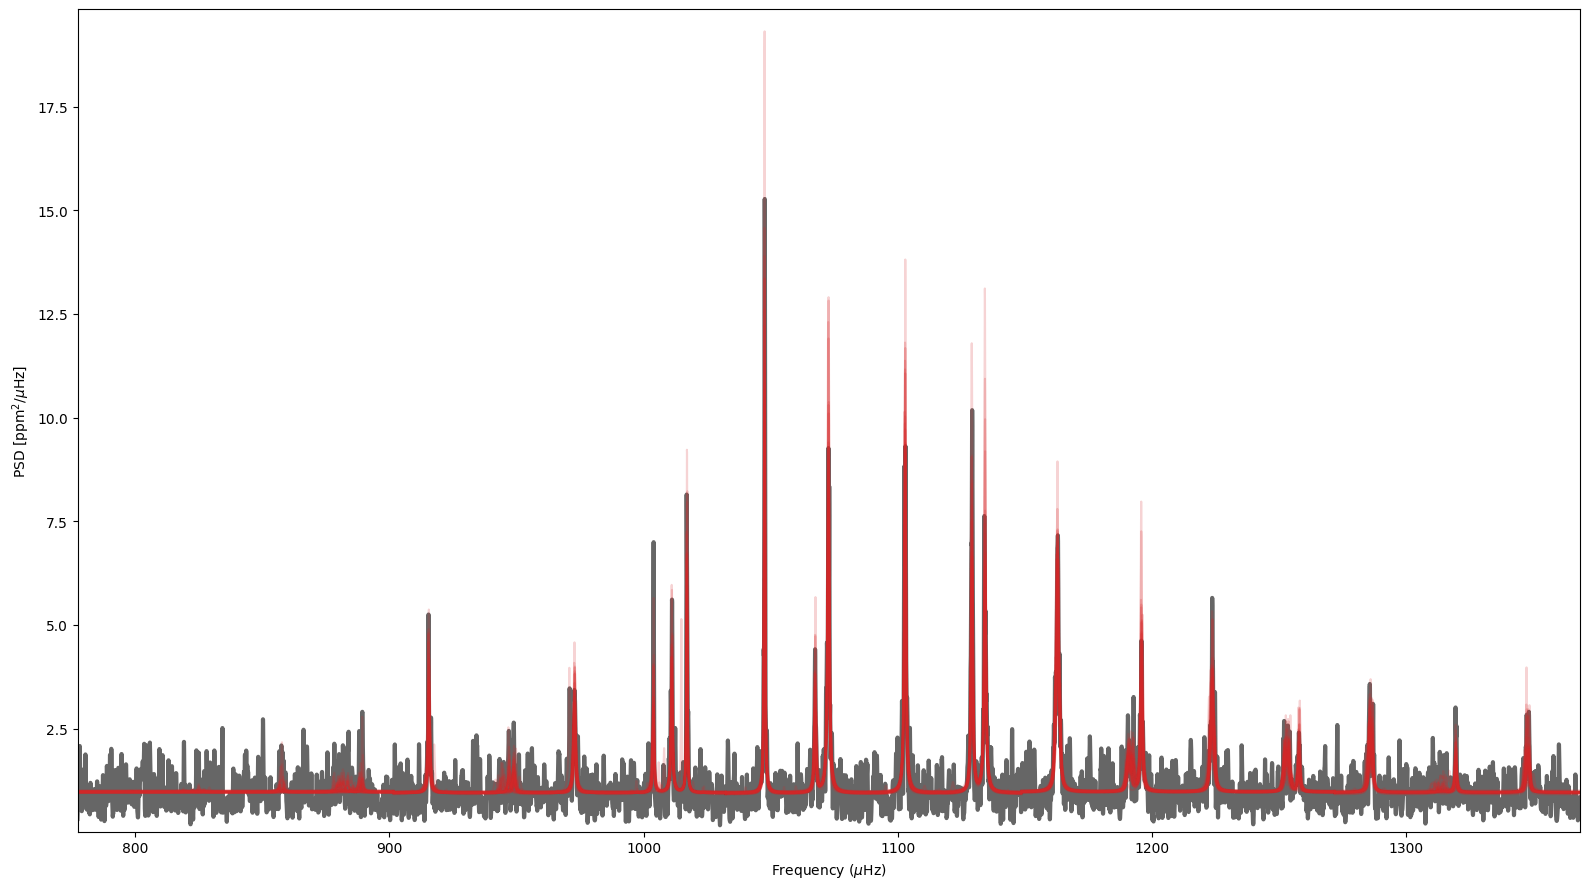

In [5]:
pb.spectrum();

## Getting a single value of the rotation and inclination with slices

**Note** If you always just do global peakbagging you can ignore this section.

One downside to using the slicing technique to fit the modes is that properties like inclination and rotation, which are in principle shared amongst all the modes, must be fit independently for each slice. We therefore include an option to compute the joint probability of the posterior distributions for the inclination and rotation parameters of all the slices. 

This is not the optimal way of measuring these parameters however, so if you care about them, it is best to avoid using the slicing method. The entire envelope should be fit at the same time.

In [6]:
pb.getRotationInclination()

100%|█████████████████████████████████████████| 500/500 [04:19<00:00,  1.93it/s]
